In [6]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
import cv2
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from keras.utils import to_categorical

Test Basic Models on multiclass Dataset + Make overall ROC/AUC

Data Preparation

In [3]:
normal_X = pickle.load(open('pickled_data/normal.pkl', "rb" ))
covid_X = pickle.load(open('pickled_data/covid.pkl', "rb" ))
tb_X = pickle.load(open('pickled_data/tb.pkl', "rb" ))
bpneumonia_X = pickle.load(open('pickled_data/bpneumonia.pkl', "rb" ))
vpneumonia_X = pickle.load(open('pickled_data/vpneumonia.pkl', "rb" ))
NUM_NORMAL = len(normal_X)
NUM_COVID = len(covid_X)
NUM_TB = len(tb_X)
NUM_BPNEUMONIA = len(vpneumonia_X)
NUM_VPNEUMONIA = len(vpneumonia_X)
NUM_LIST = [NUM_NORMAL, NUM_COVID, NUM_TB, NUM_BPNEUMONIA, NUM_VPNEUMONIA]
MULTI_LIST = ['NORMAL', 'COVID', 'TB', 'BPNEUMONIA', 'VPNEUMONIA']

In [7]:
X = np.concatenate([normal_X, covid_X, tb_X, bpneumonia_X, vpneumonia_X], axis=0)
X = X.reshape((X.shape[0], -1))
y = np.array([0]*NUM_NORMAL + [1]*NUM_COVID + [2]*NUM_TB + [3]*NUM_BPNEUMONIA + [4]*NUM_VPNEUMONIA)
encoded_y = to_categorical(y)

Data Visualization

PCA to compare normal data from different sources, t-SNE from sklearn, PCA then t-SNE

Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [8]:
principalComponents = PCA(n_components=2).fit_transform(X)
tSNEComponents = TSNE(n_components=2).fit_transform(X)
PC_tSNEComponents = TSNE(n_components=2).fit_transform(PCA(n_components=50).fit_transform(X))

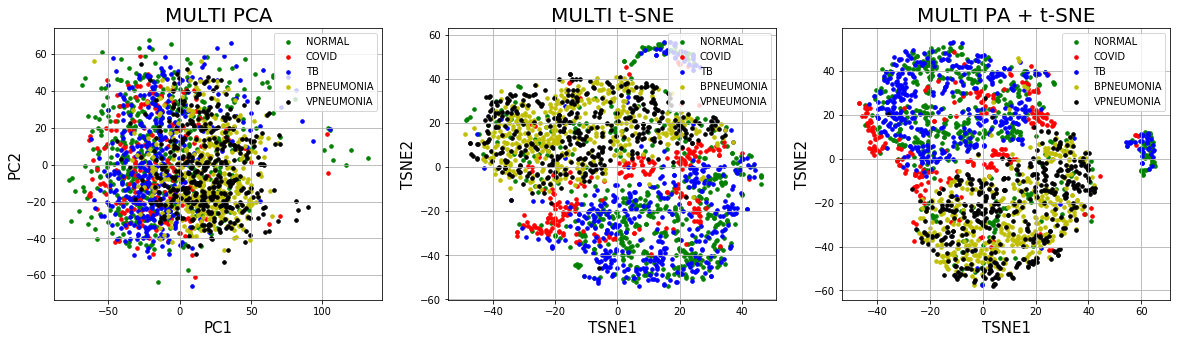

In [10]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
labels = list(map(lambda i:MULTI_LIST[i], y))
principalDf['target'] = labels

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('MULTI PCA', fontsize = 20)
targets = MULTI_LIST
colors = ['g', 'r', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets, loc='upper right')
ax.grid()

principalDf = pd.DataFrame(data = tSNEComponents, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:MULTI_LIST[i], y))
principalDf['target'] = labels

ax = fig.add_subplot(1,3,2) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('MULTI t-SNE', fontsize = 20)
targets = MULTI_LIST
colors = ['g', 'r', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets, loc='upper right')
ax.grid()


principalDf = pd.DataFrame(data = PC_tSNEComponents, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:MULTI_LIST[i], y))
principalDf['target'] = labels

ax = fig.add_subplot(1,3,3) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('MULTI PA + t-SNE', fontsize = 20)
targets = MULTI_LIST
colors = ['g', 'r', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets, loc='upper right')
ax.grid()

Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [11]:
clf = LogisticRegression(random_state=0, class_weight='balanced', multi_class='ovr')

In [12]:
# First need to cross validate model
cv_results = cross_validate(clf, X, y, cv=5)
print('CV: {}'.format(np.mean(cv_results['test_score'])))

CV: 0.5483701190825201


In [13]:
# Gather statistics about logistic regression
lr = clf.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       103
           1       0.62      0.63      0.63        41
           2       0.67      0.61      0.64        72
           3       0.50      0.52      0.51        75
           4       0.54      0.58      0.56        88

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.59       379
weighted avg       0.59      0.59      0.59       379



Visualize the weights of logistic regression and overlay them with actual images

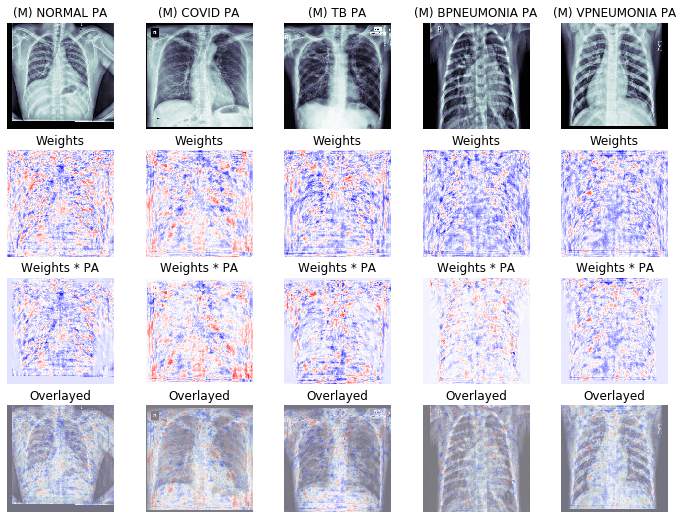

In [17]:
images = [X_test[2],
          X_test[11],
          X_test[1],
          X_test[15],
          X_test[3]]

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12,9), sharey=True, sharex=True)
[axi.set_axis_off() for axi in ax.ravel()]
for i in range(len(lr.coef_)):
    weights = lr.coef_[i].reshape((224, 224, 3))
    ax[1, i].imshow(weights[:, :, 0], cmap="bwr")
    ax[1, i].set_title('Weights')
    
    real_image = images[i].reshape((224, 224, 3))[:, :, 0]
    ax[2, i].imshow(weights[:, :, 0]*real_image, cmap="bwr")
    ax[2, i].set_title('Weights * PA')
    
    ax[0, i].imshow(real_image, cmap=plt.cm.bone)
    ax[0, i].set_title('(M) {} PA'.format(MULTI_LIST[i]))
    
    ax[3, i].imshow(weights[:, :, 0] * real_image, cmap="bwr")
    ax[3, i].imshow(real_image, cmap=plt.cm.bone, alpha=.5)
    ax[3, i].set_title('Overlayed')

k-Nearest Neighbors

In [18]:
knn = KNeighborsClassifier(weights='distance')
cv_results = cross_validate(knn, X, y, cv=5)
print('CV: {}'.format(np.mean(cv_results['test_score'])))

CV: 0.5853764431600843


In [19]:
y_pred = knn.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       103
           1       0.72      0.76      0.74        41
           2       0.71      0.57      0.63        72
           3       0.52      0.73      0.61        75
           4       0.60      0.59      0.60        88

    accuracy                           0.62       379
   macro avg       0.64      0.64      0.64       379
weighted avg       0.64      0.62      0.62       379

